/var/folders/rf/c2h39lmj3cddypp2tpdfvlpr0000gn/T/ipykernel_8829/3872902888.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('MELI', start='2018-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'Cotización ajustada de Mercado Libre'}, xlabel='Date'>

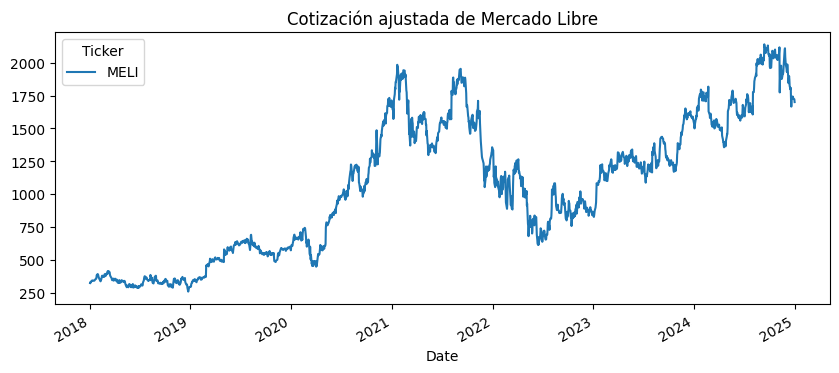

In [86]:
import yfinance as yf

# Descargar cotizaciones de MELI (Mercado Libre)
data = yf.download('MELI', start='2018-01-01', end='2025-01-01')
series = data['Close'].dropna().astype(float)
#data = data.asfreq('B')  # B: días hábiles
#data = data.fillna(method='ffill')  # Rellenar valores faltantes
series.plot(title="Cotización ajustada de Mercado Libre", figsize=(10,4))



In [87]:
series

Ticker,MELI
Date,
2018-01-02,322.579987
2018-01-03,329.279999
2018-01-04,325.880005
2018-01-05,330.869995
2018-01-08,340.790009
...,...
2024-12-24,1743.290039
2024-12-26,1732.760010
2024-12-27,1725.469971


In [26]:
from statsmodels.tsa.stattools import adfuller

# ADF test
resultado = adfuller(series.dropna())

print('Estadístico ADF:', resultado[0])
print('p-valor:', resultado[1])
print('Valores críticos:')
for clave, valor in resultado[4].items():
    print(f'   {clave}: {valor}')


Estadístico ADF: -1.4722437018905474
p-valor: 0.5471945905127297
Valores críticos:
   1%: -3.4340709449678415
   5%: -2.8631835901181564
   10%: -2.567644997740186


In [82]:
data_diff = series.diff().dropna()
#data_diff.plot(title="Serie diferenciada de MELI (1ra diferencia)", figsize=(10,4))


In [31]:
resultado_diff = adfuller(data_diff)

print('Estadístico ADF (diferenciada):', resultado_diff[0])
print('p-valor:', resultado_diff[1])

Estadístico ADF (diferenciada): -41.759898533212436
p-valor: 0.0


In [83]:
from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(series, order=(1,1,1))  # p=1, d=1, q=1 como punto de partida
resultado = modelo.fit()
#print(resultado.summary())


/Users/juaninaki/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/juaninaki/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/juaninaki/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/juaninaki/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starti

In [85]:
#resultado.plot_diagnostics(figsize=(12,8))

/var/folders/rf/c2h39lmj3cddypp2tpdfvlpr0000gn/T/ipykernel_8829/1370526114.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data1 = yf.download('MELI', start='2018-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


RMSE Rolling ARIMA: 37.2641


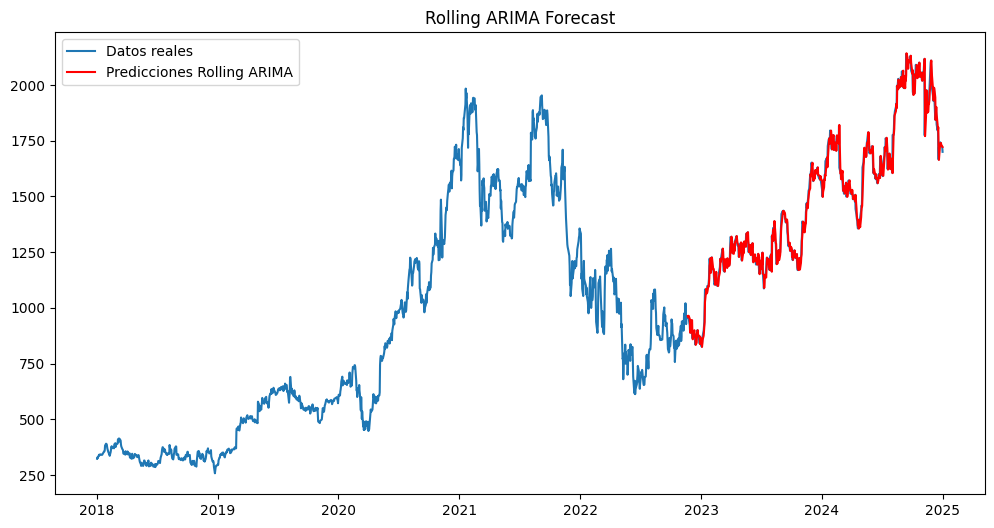

In [70]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#ARIMA
# 1. División 70% entrenamiento, 30% test
size = int(len(series) * 0.7)
train, test = series.iloc[:size], series.iloc[size:]

history = train.tolist() # 4. historial inicial con datos de entrenamiento
predictions = []            # 3. lista vacía para pronósticos
history = [float(x) for x in history if pd.notna(x)]

# 6. Rolling forecast paso a paso
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))   # 7. modelo ARIMA(5,1,0)
    model_fit = model.fit()
    forecast = model_fit.forecast()          # 9. pronóstico 1 paso adelante
    yhat = forecast[0]                       # valor pronosticado
    predictions.append(yhat)                 # 10. guardar pronóstico
    obs = test.iloc[t]                       # 11. dato real
    history.append(obs)                      # 12. actualizar historial con valor real

# 14-15. Calcular RMSE
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE Rolling ARIMA: {rmse:.4f}')

# Graficar resultados
plt.figure(figsize=(12,6))
plt.plot(series.index, series, label='Datos reales')
plt.plot(test.index, predictions, color='red', label='Predicciones Rolling ARIMA')
plt.legend()
plt.title('Rolling ARIMA Forecast')
plt.show()


In [90]:
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error
import math

In [114]:
# Normalización simple (Min-Max)
min_val = series.min()
max_val = series.max()
series_norm = (series - min_val) / (max_val - min_val)

# Extraer la columna de valores (1D)
values = series_norm['MELI'].values

# División train-test
size = int(len(values) * 0.7)
train, test = values[:size], values[size:]

# Crear dataset para LSTM
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 10  # podés probar 5, 10, 20
trainX, trainY = create_dataset(train, look_back)
trainX = trainX.reshape((trainX.shape[0], look_back, 1))

# Fijar semilla para reproducibilidad
np.random.seed(7)
tf.random.set_seed(7)

def fit_lstm(trainX, trainY, epochs=1, neurons=4):
    model = Sequential()
    model.add(Input(batch_shape=(1, 1, 1)))  # para stateful=True batch_size=1
    model.add(LSTM(neurons, stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    model.fit(trainX, trainY, epochs=epochs, batch_size=1, shuffle=False, verbose=0)
    return model

def rolling_forecast_lstm(model, train, test):
    history = list(train)
    predictions = []
    
    for i in range(len(test)):
        X = np.array(history[-1]).reshape((1,1,1))
        yhat = model.predict(X, batch_size=1, verbose=0)
        predictions.append(yhat[0,0])
        history.append(test[i])
    return predictions

# Valores para epochs a probar
epochs_list = [1, 5, 10, 25,50]
neurons = 8

for epochs in epochs_list:
    # Entrenar modelo
    model = fit_lstm(trainX, trainY, epochs=epochs, neurons=neurons)
    
    # Predecir con walk-forward
    predictions = rolling_forecast_lstm(model, train, test)
    
    # Desnormalizar
    min_val = series['MELI'].min()
    max_val = series['MELI'].max()
    predictions_rescaled = [p * (max_val - min_val) + min_val for p in predictions]
    test_rescaled = [t * (max_val - min_val) + min_val for t in test]
    
    # Calcular RMSE
    rmse = math.sqrt(mean_squared_error(test_rescaled, predictions_rescaled))
    print(f"Epochs: {epochs} => RMSE Rolling LSTM: {rmse:.4f}")


Epochs: 1 => RMSE Rolling LSTM: 437.1632
Epochs: 5 => RMSE Rolling LSTM: 359.6962
Epochs: 10 => RMSE Rolling LSTM: 328.3217
Epochs: 25 => RMSE Rolling LSTM: 235.9536
Epochs: 50 => RMSE Rolling LSTM: 185.9940
